In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

<b>Load ORL dataset and convert into numpy arrays

In [2]:
orl_path = "ORL"

img = []
labels = []

for cls, person_folder in enumerate(sorted(os.listdir(orl_path))):
    person_folder_path = os.path.join(orl_path, person_folder)
    if not os.path.isdir(person_folder_path):
        continue

    for file_name in os.listdir(person_folder_path):
        if file_name.lower().endswith(('.bmp')):
            image_path = os.path.join(person_folder_path, file_name)

            image = Image.open(image_path).convert("L").resize((64,64))
            image_array = np.array(image).flatten()
            img.append(image_array)
            labels.append(cls)

X = np.array(img, dtype=np.float32)
y = np.array(labels)           
X_norm = X / 255.0

<b>Standardization for easier implementation of PCA

In [3]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_norm)

<b>Splitting the dataset into training set and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(280, 4096) (120, 4096) (280,) (120,)


<b>Plotting the variance ratio vs principal components number

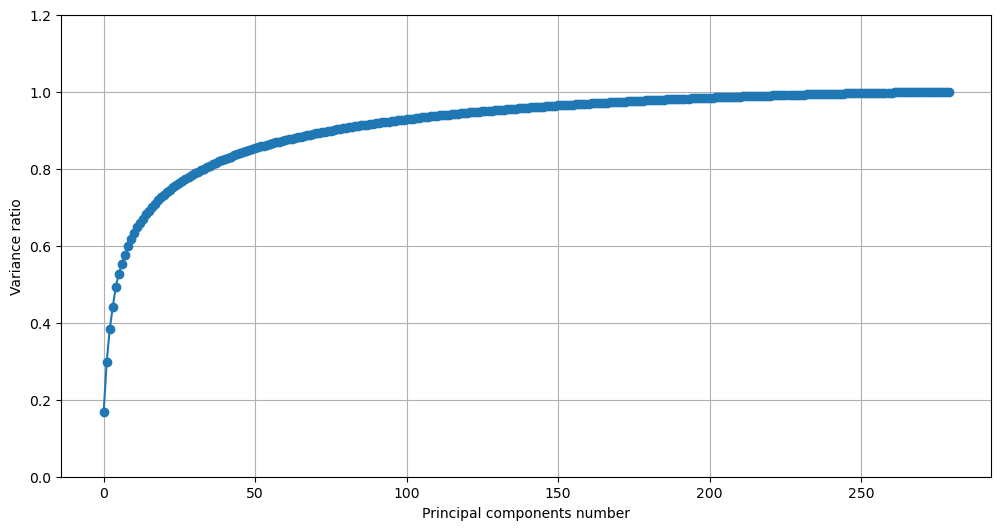

In [5]:
pca = PCA()
pca.fit(X_train)
evr = pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(evr), marker="o")
plt.xlabel("Principal components number")
plt.ylabel("Variance ratio")
plt.ylim(0, 1.2)
plt.grid(True)
plt.show()


<b>Plotting first 2 principal components

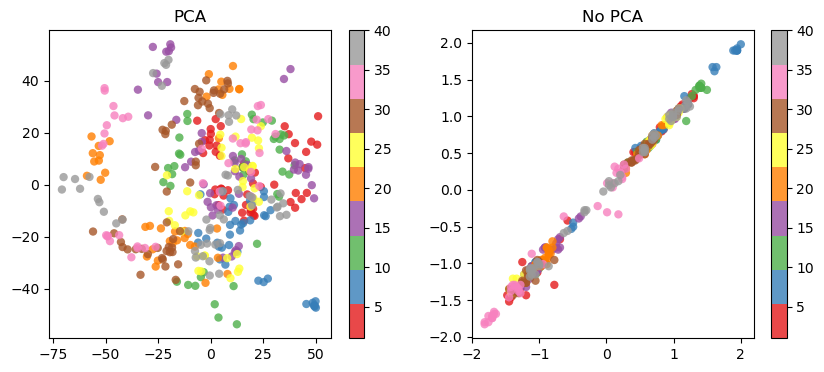

In [6]:
X_embedded = pca.transform(X_std)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y, edgecolor="none", alpha=0.8, cmap=plt.colormaps["Set1"])
plt.title("PCA")
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(X_std[:,0], X_std[:,1], c=y, edgecolor="none", alpha=0.8, cmap=plt.colormaps["Set1"])
plt.title("No PCA")
plt.colorbar()


plt.show()

<b>Plotting the first 10 eigenfaces/components

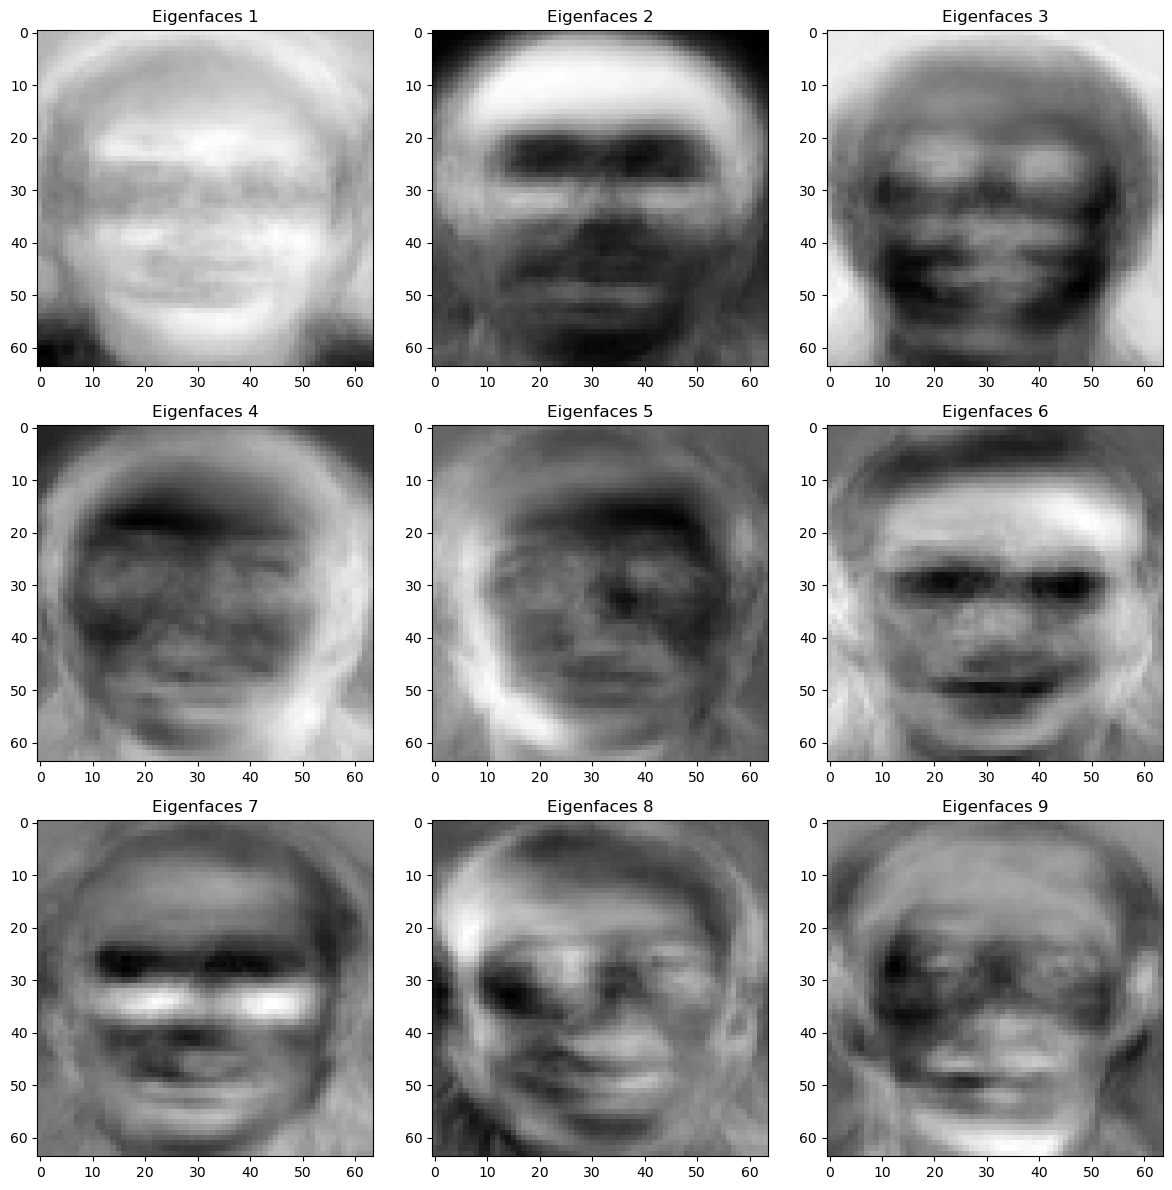

In [7]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(pca.components_[i].reshape(64,64), cmap='gray')
    plt.title("Eigenfaces "+ str(i+1))
plt.tight_layout()
plt.show()

<b>Define the classifiers

In [8]:
nn = KNeighborsClassifier(n_neighbors=1)
knn = KNeighborsClassifier(n_neighbors=3)
nc = NearestCentroid(shrink_threshold=None)

models = [( "NearestNeighbors", nn), ( "KNearestNeighbors", knn), ( "NearestCentroid", nc)]

<b> Selecting the optimal number of principal components

In [9]:
for name,model in models:
    rows = []
    for n_components in [200, 150, 100, 50, 35, 30, 25, 20, 15, 10, 7, 5]:
        pca = PCA(n_components=n_components)
        pca.fit(X_train)

        model.fit(pca.transform(X_train), y_train)
        accuracy = model.score(pca.transform(X_test), y_test)
        variation_ratio = sum(pca.explained_variance_ratio_)
               
 
        rows.append({"Components number": n_components,"Variation ratio": variation_ratio,"Accuracy": accuracy})
    df = pd.DataFrame(rows)
    print(f"\nModel: {name}")
    display(df)


Model: NearestNeighbors


,Components number,Variation ratio,Accuracy
0,200,0.983989,0.950000
1,150,0.963283,0.941667
2,100,0.926904,0.950000
3,50,0.850217,0.941667
4,35,0.804041,0.950000
5,30,0.782925,0.950000
6,25,0.757706,0.933333
7,20,0.725520,0.916667
8,15,0.681554,0.933333
9,10,0.617690,0.941667



Model: KNearestNeighbors


,Components number,Variation ratio,Accuracy
0,200,0.983975,0.883333
1,150,0.963186,0.875000
2,100,0.927068,0.875000
3,50,0.850328,0.850000
4,35,0.804150,0.866667
5,30,0.782935,0.866667
6,25,0.757713,0.866667
7,20,0.725516,0.841667
8,15,0.681556,0.850000
9,10,0.617691,0.883333



Model: NearestCentroid


,Components number,Variation ratio,Accuracy
0,200,0.983997,0.916667
1,150,0.963195,0.916667
2,100,0.927006,0.908333
3,50,0.850362,0.900000
4,35,0.804089,0.900000
5,30,0.783051,0.900000
6,25,0.757716,0.875000
7,20,0.725519,0.858333
8,15,0.681556,0.850000
9,10,0.617691,0.825000


<b>Selecting best shrink_treshold for Nearest Prototype

In [10]:
for shrink_threshold in [None, 0.1, 0.2]:
    model = NearestCentroid(shrink_threshold=shrink_threshold)
    pca = PCA(n_components=100)
    pca.fit(X_train)

    model.fit(pca.transform(X_train), y_train)
    accuracy = model.score(pca.transform(X_test), y_test)
    print(f"Shrink threshold:{shrink_threshold}\nAccuracy:{accuracy}")

Shrink threshold:None
Accuracy:0.9166666666666666
Shrink threshold:0.1
Accuracy:0.9
Shrink threshold:0.2
Accuracy:0.9


<b>Models performance evaluation

NearestNeighbors
Accuracy score: 0.9583333333333334
Precision score: 0.9666666666666666
Recall score: 0.9583333333333333
F1 score: 0.9573809523809522


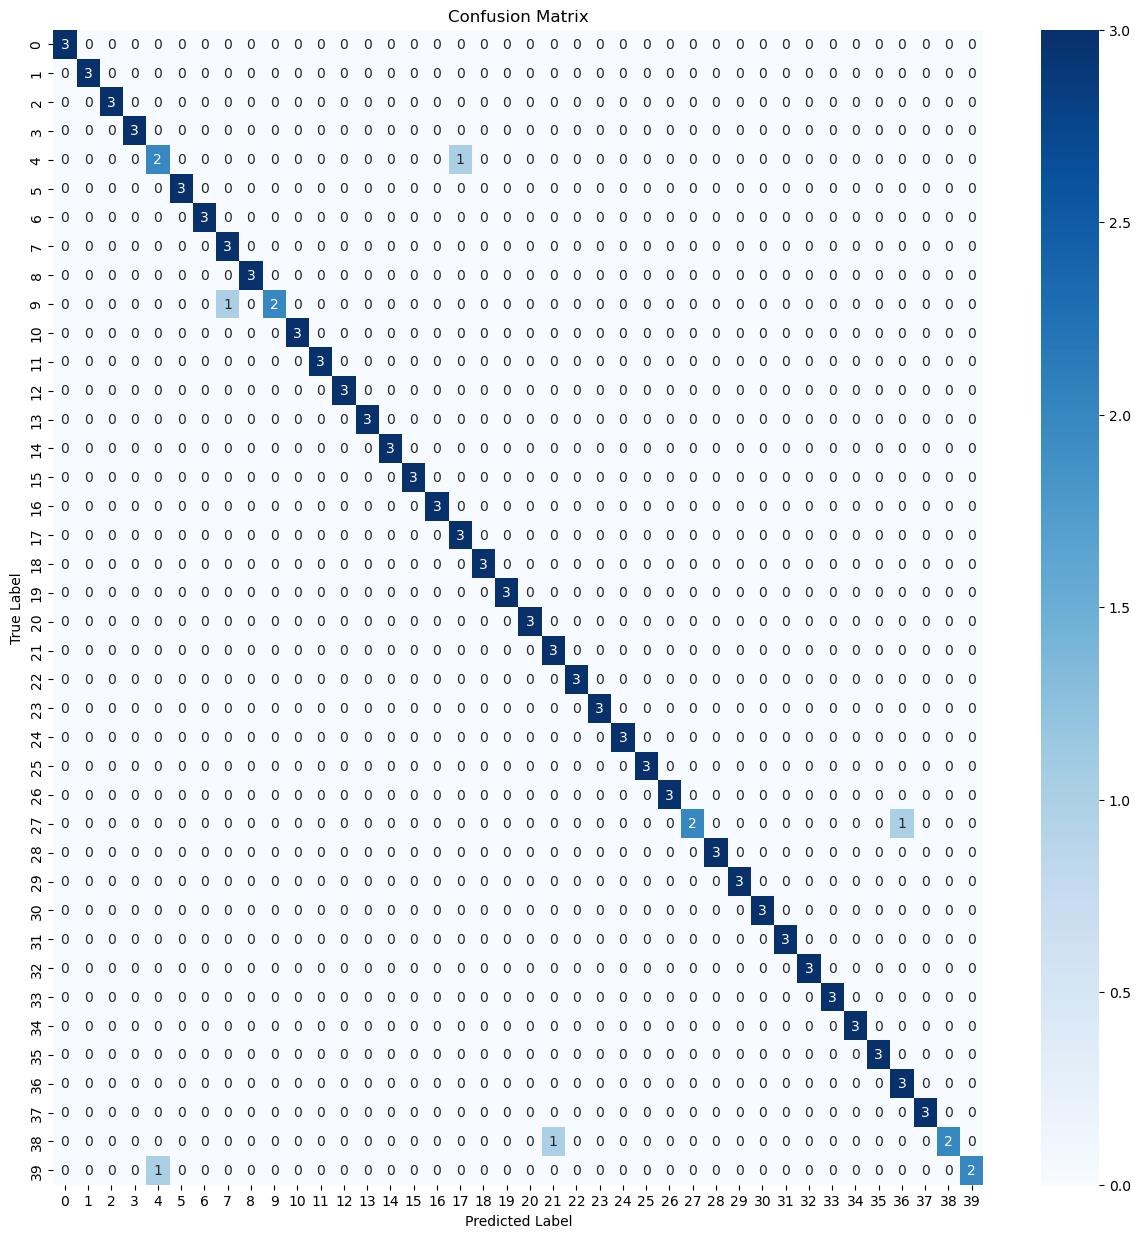

KNearestNeighbors
Accuracy score: 0.8833333333333333
Precision score: 0.9204166666666665
Recall score: 0.8833333333333332
F1 score: 0.8833333333333334


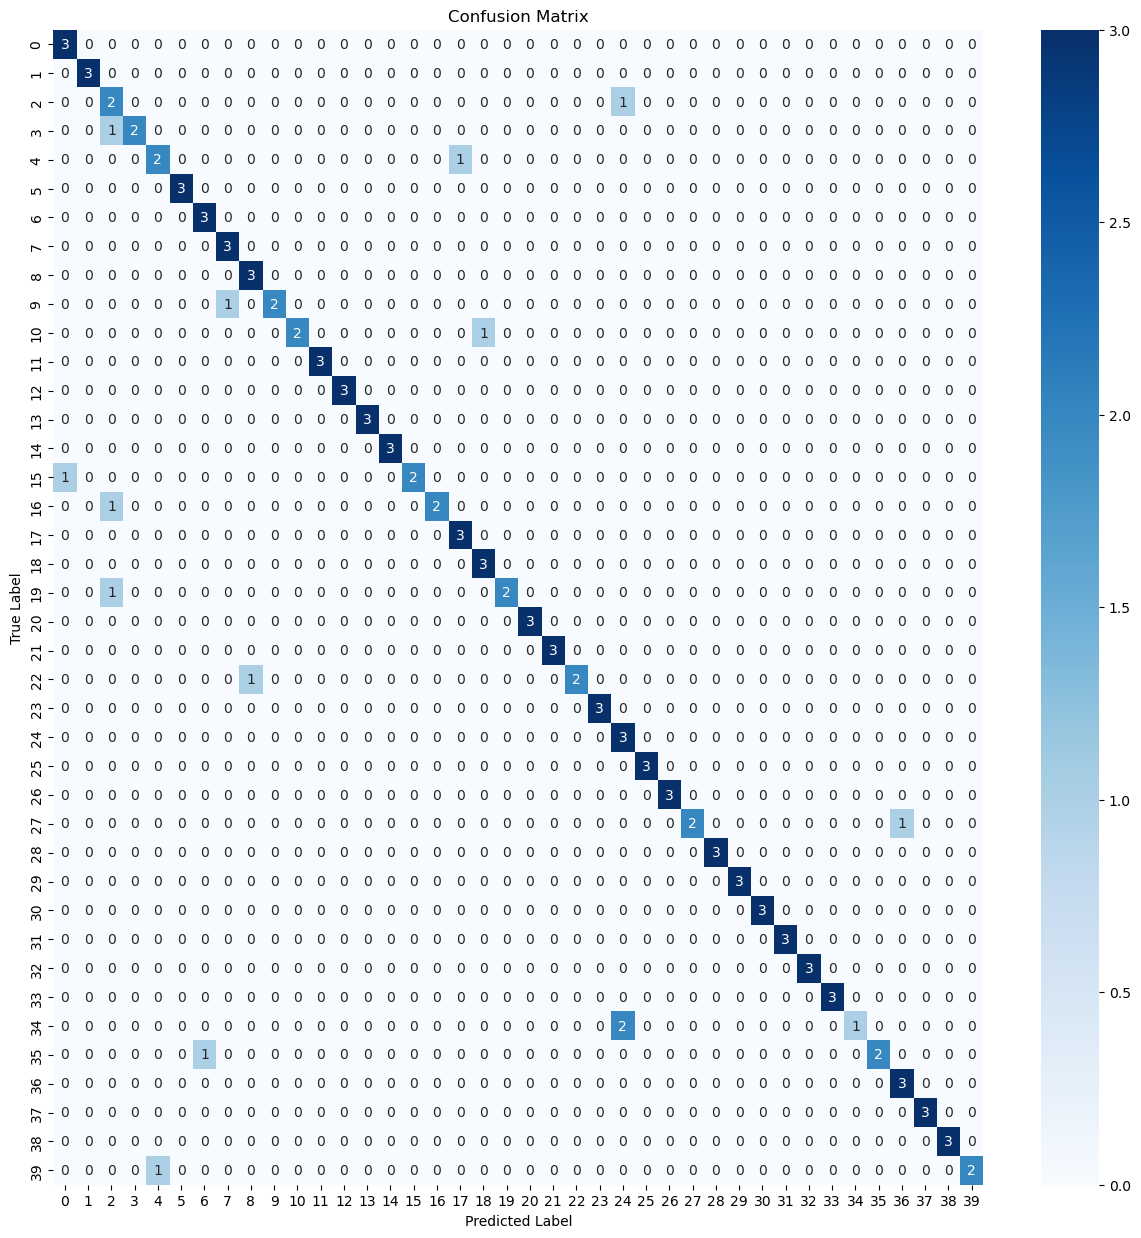

NearestCentroid
Accuracy score: 0.9166666666666666
Precision score: 0.9358333333333333
Recall score: 0.9166666666666667
F1 score: 0.913154761904762


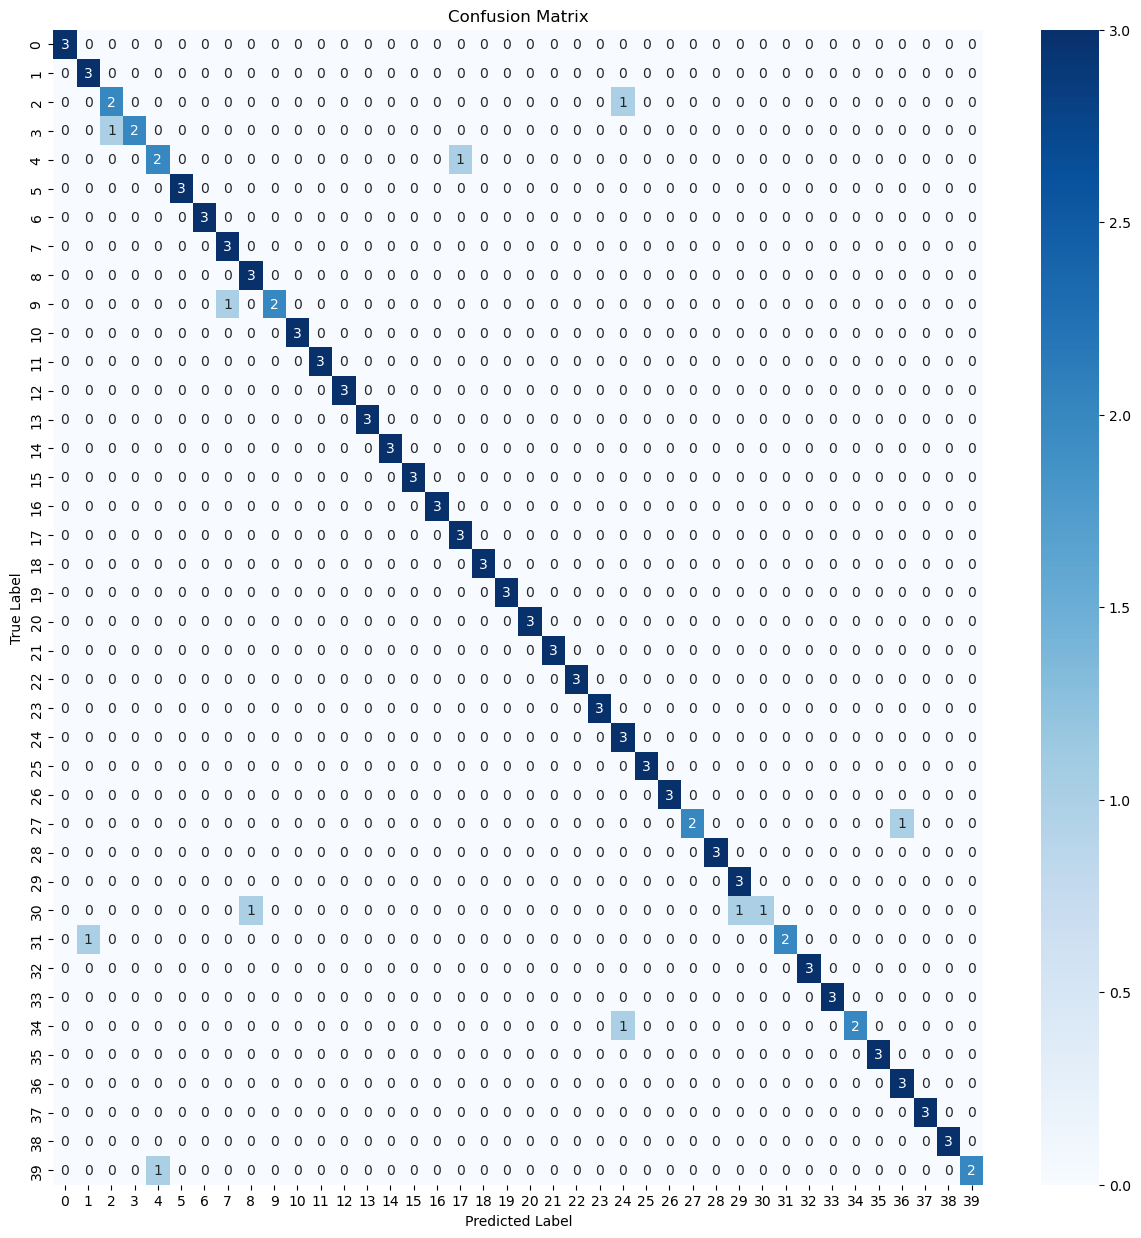

In [11]:
pca = PCA(n_components=100)
pca.fit(X_train)
   
for name,model in models:
    model.fit(pca.transform(X_train), y_train)
    y_pred = model.predict(pca.transform(X_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(name)
    print("Accuracy score:", accuracy)
    print("Precision score:", precision)
    print("Recall score:", recall)
    print("F1 score:", f1)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(15,15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    

<b>Selecting the optimal train-test split

In [12]:
for test_size in [0.5,0.4,0.3,0.2]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True, stratify=y)
    rows = []
    for name,model in models:
        pca = PCA(n_components=100)
        pca.fit(X_train)

        model.fit(pca.transform(X_train), y_train)
        accuracy = model.score(pca.transform(X_test), y_test)
               
        rows.append({"Train/Test":(str(100 - test_size*100) + "%" + " / " + str(test_size*100) + "%"),"Model":name,"Accuracy": accuracy})
    df = pd.DataFrame(rows)
    display(df)

,Train/Test,Model,Accuracy
0,50.0% / 50.0%,NearestNeighbors,0.950
1,50.0% / 50.0%,KNearestNeighbors,0.865
2,50.0% / 50.0%,NearestCentroid,0.915


,Train/Test,Model,Accuracy
0,60.0% / 40.0%,NearestNeighbors,0.94375
1,60.0% / 40.0%,KNearestNeighbors,0.88125
2,60.0% / 40.0%,NearestCentroid,0.91250


,Train/Test,Model,Accuracy
0,70.0% / 30.0%,NearestNeighbors,0.950000
1,70.0% / 30.0%,KNearestNeighbors,0.883333
2,70.0% / 30.0%,NearestCentroid,0.916667


,Train/Test,Model,Accuracy
0,80.0% / 20.0%,NearestNeighbors,0.9500
1,80.0% / 20.0%,KNearestNeighbors,0.9250
2,80.0% / 20.0%,NearestCentroid,0.8875
